# Analysis of Coronavirus Vaccination Rates
## Olivia Taylor

I chose to explore topic of coronavirus vaccination rates. Over the past two years we have collectively experienced a trauma due to the novel Coronavirus and the various efforts to lessen its impact. Multiple vaccines were developed in record time, some of which were mRNA vaccines which is a new technology that will create . Since then we have been working to mitigate the effects of the coronavirus by distributing vaccines and as of November 24, 2021 over half of the global population has received at least one dose of a vaccine, and 42.7% of the world is now fully vaccinated.

While more and more people are receiving the vaccines, these vaccines are not distributed uniformly and countries have varying vaccination rates with the United Arab Emirates as of 11/15/2021 having 98% of its population at least partially vaccinated leading. And some countries having extremely low rates such as the Democratic Republic of Congo where less than one percent of the population have received a dose as of 12/7/2021.

I want to explore the potential factors that impact vaccination rates with a special focus on political violence. While it is easy to assume that markers such as GDP and human development index have a significant impact on vaccination rates globally, there is little study on political violence and how that has impacted coronavirus vaccination rates, despite the amount of violence that is occurring throughout the world. In the past couple of years, political violence has been prominent in the news in many countries around the world. Myanmar had a military coup last February and the country has been cut off from the rest of the world since https://www.bbc.com/news/world-asia-55902070. There has been civil war going on in Ethiopia with the country on the brink of collapse https://www.nytimes.com/article/ethiopia-tigray-conflict-explained.html. And even in the US we had the events of January 6th which no one will forget at any point soon.

The goal will be to create a model that will predict vaccination rates within countries provided certain data including political violence and HDI.

## Data Collection:

There are two relevant datasets that I have found. Our World in Data (OWID) has comprehensive data on coronavirus vaccinations and the data is updated on a daily basis. I will be using the OWID Covid data as well as data from the Armed Conflict Location & Event Data Project (ACLED) whose dataset covers conflict internationally with many features including location, date of event, actors, casualties, and source of information among others.

OWID Covid site: https://ourworldindata.org/coronavirus

OWID Covid data: https://github.com/owid/covid-19-data

ACLED site: https://acleddata.com/#/dashboard

ACLED data can be obtained by making a free account.

In [1]:
import seaborn as sns
import numpy as np
import csv
import pandas as pd
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from scipy.stats import norm
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from numpy import mean
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor




In [2]:
latest = pd.read_csv('owid-covid-latest.txt')
total = pd.read_csv('owid-covid-data.csv')
acled = pd.read_csv('acled.csv')

## Data Processing

In this next section we will process the data so that it can be easily explored and manipulated in the future. The result will be two datasets. The first one will contain the total vaccination rates along with the total fatalities due to political violence for each country, where the fatalities are normalized by population. The second dataset will be a time series that has vaccination rates taken at one week intervals in each country with a column added for the number of deaths due to violence that has occurred in that country since the last interval. 

The OWID vaccination data has 138,727 observations and 67 features and the ACLED data has 731,342 observations and 31 features, and the cleaned data that we will be working with needs to shorten and combine these in a way that is workable.

In [3]:
# first we remove the irrelevant columns and make sure that only countries and not regions are being represented in
# the data. Then we drop the entries missing data that is relevant. We then work with the the date info to make
# it easy to use in the future
latest = latest[['iso_code', 'continent', 'location', 'population', 'last_updated_date', 'total_cases_per_million', 'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred', 'total_vaccinations_per_hundred','gdp_per_capita', 'human_development_index']]
latest.dropna(subset=['total_vaccinations_per_hundred', 'people_vaccinated_per_hundred','last_updated_date', 'location','iso_code','continent'], inplace=True)
latest['last_updated_date']=pd.to_datetime(latest['last_updated_date'])

total = total[['iso_code', 'continent', 'location', 'population_density','population', 'date', 'total_cases_per_million', 'people_vaccinated_per_hundred', 'total_vaccinations_per_hundred','gdp_per_capita', 'human_development_index']]
total.dropna(subset=['total_vaccinations_per_hundred', 'people_vaccinated_per_hundred','date', 'location','iso_code','continent'], inplace=True)
total['date']=pd.to_datetime(total['date'])
total['month']= total.apply(lambda row: row['date'].month, axis=1)
total['year']= total.apply(lambda row: row['date'].year, axis=1)

# create a string date variable for just the month and year
def year_month(val):
    if val['month'] < 10:
        return str(val['year']) + "/0" + str(val['month'])
    return str(val['year']) + "/" + str(val['month'])
# compresses the data into one month chunks rather than all of the entries we had before
def vax_month_per_hundred(val):
    month = val['month']
    year = val['year']
    iso = val['iso_code']
    v = total[total['year'] == year]
    v = v[v['month'] == month]
    return v[v['iso_code'] == iso]['total_vaccinations_per_hundred'].max()
total['year_month'] = total.apply(lambda row: year_month(row), axis = 1)
total['vax_month_per_hundred'] = total.apply(lambda row: vax_month_per_hundred(row), axis=1)
total = total.drop_duplicates(subset=['year_month', 'iso_code'], keep='last')


In [4]:
# we are only interested in the violent events that resulted in deaths
acled = acled[acled['fatalities'] > 0]
acled = acled[['iso3','event_date','event_type','fatalities']]
acled['event_date']=pd.to_datetime(acled['event_date'])
acled['month']=acled.apply(lambda row: row['event_date'].month, axis=1)
acled['year']=acled.apply(lambda row: row['event_date'].year, axis=1)

# gives the sum per country of deaths due to political violence
def violence(val):
    iso = val['iso_code']
    return acled[acled['iso3'] == iso]['fatalities'].sum()
latest['fatalities'] = latest.apply(lambda row: violence(row),axis=1)
latest['death_per_million'] = (latest['fatalities'] / latest['population'])*1000000
latest['fatalities_over_100'] = latest['fatalities'] > 100

# creates a sum for deaths due to political violence for the month for each country
def violence(val):
    iso = val['iso_code']
    month = val['month']
    year = val['year']
    c = acled[acled['month'] == month]
    c = c[c['year'] == year]
    return c[c['iso3']==iso]['fatalities'].sum()
total['fatalities'] = total.apply(lambda row: violence(row), axis=1)
total['death_per_million'] = (total['fatalities'] / total['population'])*1000000
total = total[['iso_code', 'continent', 'location', 'year_month', 'vax_month_per_hundred','fatalities','death_per_million', 'population_density','gdp_per_capita', 'human_development_index']]


Now we have cleaned and consolidated the data. There is now an entry for every country for every month in the larger dataset we are working with with entries for political deaths normalized by population.

In [5]:
total.head(10)

,iso_code,continent,location,year_month,vax_month_per_hundred,fatalities,death_per_million,population_density,gdp_per_capita,human_development_index
370,AFG,Asia,Afghanistan,2021/02,0.02,2751,69.059130,54.422,1803.987,0.511
386,AFG,Asia,Afghanistan,2021/03,0.14,2399,60.222775,54.422,1803.987,0.511
423,AFG,Asia,Afghanistan,2021/04,0.60,3586,90.020371,54.422,1803.987,0.511
461,AFG,Asia,Afghanistan,2021/05,1.51,6378,160.108735,54.422,1803.987,0.511
492,AFG,Asia,Afghanistan,2021/06,2.23,8551,214.658168,54.422,1803.987,0.511
503,AFG,Asia,Afghanistan,2021/07,2.42,8763,219.980064,54.422,1803.987,0.511
554,AFG,Asia,Afghanistan,2021/08,4.97,5874,147.456681,54.422,1803.987,0.511
584,AFG,Asia,Afghanistan,2021/09,5.95,176,4.418178,54.422,1803.987,0.511
642,AFG,Asia,Afghanistan,2021/11,13.13,163,4.091835,54.422,1803.987,0.511
1650,ALB,Europe,Albania,2021/01,0.02,0,0.000000,104.871,11803.431,0.795


In [6]:
latest.head(10)

,iso_code,continent,location,population,last_updated_date,total_cases_per_million,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,gdp_per_capita,human_development_index,fatalities,death_per_million,fatalities_over_100
2,ALB,Europe,Albania,2872934.0,2021-12-11,70841.864,38.02,34.20,75.40,11803.431,0.795,1,0.348076,False
3,DZA,Africa,Algeria,44616626.0,2021-12-11,4766.205,15.41,12.08,27.55,13913.839,0.748,81,1.815467,False
4,AND,Europe,Andorra,77354.0,2021-12-11,251312.149,72.52,65.07,137.59,NaN,0.868,0,0.000000,False
5,AGO,Africa,Angola,33933611.0,2021-12-11,1927.204,20.64,9.77,30.41,5819.495,0.581,155,4.567743,True
6,AIA,North America,Anguilla,15125.0,2021-12-08,NaN,66.64,60.98,134.11,NaN,NaN,0,0.000000,False
7,ATG,North America,Antigua and Barbuda,98728.0,2021-12-11,42125.841,62.21,58.08,120.30,21490.943,0.778,1,10.128839,False
8,ARG,South America,Argentina,45605823.0,2021-12-11,117460.549,81.78,67.85,156.55,18933.907,0.845,51,1.118278,False
9,ARM,Asia,Armenia,2968128.0,2021-12-11,115360.591,28.16,17.42,45.58,8787.580,0.776,52,17.519460,False
10,ABW,North America,Aruba,107195.0,2021-12-10,NaN,78.30,73.14,151.45,35973.781,NaN,0,0.000000,False
12,AUS,Oceania,Australia,25788217.0,2021-12-11,8877.116,78.35,74.69,155.71,44648.710,0.944,0,0.000000,False


## Exploratory Analysis & Data Visualization

First we will create a quick regression model for both datasets to get a preliminary glance at what variables might be have important relationships that we may want to further explore visually.

In [7]:
fit1 = smf.ols(formula="vax_month_per_hundred ~ death_per_million + continent + year_month + population_density + gdp_per_capita + human_development_index + iso_code", data=total).fit()
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     vax_month_per_hundred   R-squared:                       0.855
Model:                               OLS   Adj. R-squared:                  0.838
Method:                    Least Squares   F-statistic:                     50.07
Date:                   Mon, 20 Dec 2021   Prob (F-statistic):               0.00
Time:                           23:44:03   Log-Likelihood:                -8009.0
No. Observations:                   1817   AIC:                         1.640e+04
Df Residuals:                       1624   BIC:                         1.747e+04
Df Model:                            192                                         
Covariance Type:               nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   -107.7025      4.028    -26.741      0.000    -115.602     -99.803
continent[T.Asia]             20.0775      1.506     13.329      0.000      17.123      23.032
continent[T.Europe]           21.4040      1.621     13.206      0.000      18.225      24.583
continent[T.North America]    15.3547      1.664      9.230      0.000      12.092      18.618
continent[T.Oceania]           8.2633      2.370      3.487      0.001       3.615      12.911
continent[T.South America]    31.2075      1.891     16.505      0.000      27.499      34.916
year_month[T.2021/01]          7.4211      4.730      1.569      0.117      -1.856      16.699
year_month[T.2021/02]         21.5911      4.410      4.896      0.000      12.941      30.241
year_month[T.2021/03]         40.9969      4.278      9.584      0.000      32.606      49.387
year_month[T.2021/04]         49.4924      4.262     11.614      0.000      41.134      57.851
year_month[T.2021/05]         61.3201      4.242     14.457      0.000      53.000      69.640
year_month[T.2021/06]         72.0174      4.236     17.002      0.000      63.709      80.325
year_month[T.2021/07]         83.8472      4.242     19.767      0.000      75.527      92.167
year_month[T.2021/08]         96.5628      4.233     22.811      0.000      88.260     104.866
year_month[T.2021/09]        106.5237      4.230     25.182      0.000      98.227     114.821
year_month[T.2021/10]        115.7834      4.236     27.331      0.000     107.474     124.093
year_month[T.2021/11]        125.2460      4.234     29.579      0.000     116.941     133.551
year_month[T.2021/12]        129.5811      4.288     30.218      0.000     121.170     137.992
iso_code[T.AFG]              -10.3671     10.246     -1.012      0.312     -30.465       9.731
iso_code[T.AGO]               -8.0687      6.594     -1.224      0.221     -21.003       4.865
iso_code[T.AIA]            -2.269e-10   1.07e-10     -2.123      0.034   -4.37e-10   -1.73e-11
iso_code[T.ALB]               -8.0308      6.532     -1.230      0.219     -20.842       4.781
iso_code[T.AND]            -5.908e-10    3.5e-10     -1.687      0.092   -1.28e-09    9.61e-11
iso_code[T.ARE]               45.7648      7.616      6.009      0.000      30.826      60.703
iso_code[T.ARG]                3.7572      5.817      0.646      0.518      -7.653      15.167
iso_code[T.ARM]              -39.8834      6.898     -5.782      0.000     -53.413     -26.354
iso_code[T.ATG]               16.4232      6.198      2.650      0.008       4.266      28.580
iso_code[T.AUS]               -9.3751      6.001     -1.562      0.118     -21.146       2.396
iso_code[T.AUT]                0.2911      5.758      0.051      0.960     -11.003      11.585
iso_code[T

In [8]:
fit2 = smf.ols(formula="total_vaccinations_per_hundred ~ death_per_million + continent + gdp_per_capita + human_development_index", data=latest).fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     total_vaccinations_per_hundred   R-squared:                       0.748
Model:                                        OLS   Adj. R-squared:                  0.735
Method:                             Least Squares   F-statistic:                     57.92
Date:                            Mon, 20 Dec 2021   Prob (F-statistic):           7.07e-43
Time:                                    23:44:03   Log-Likelihood:                -794.13
No. Observations:                             165   AIC:                             1606.
Df Residuals:                                 156   BIC:                             1634.
Df Model:                                       8                                         
Covariance Type:                        nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                    -92.0948     21.241     -4.336      0.000    -134.051     -50.139
continent[T.Asia]             30.4825      8.588      3.550      0.001      13.520      47.445
continent[T.Europe]           16.4353     11.272      1.458      0.147      -5.830      38.701
continent[T.North America]    16.8918     10.235      1.650      0.101      -3.325      37.109
continent[T.Oceania]          23.3353     12.084      1.931      0.055      -0.534      47.204
continent[T.South America]    47.3670     11.800      4.014      0.000      24.059      70.674
death_per_million             -0.0165      0.012     -1.345      0.181      -0.041       0.008
gdp_per_capita                 0.0007      0.000      3.019      0.003       0.000       0.001
human_development_index      213.8837     38.195      5.600      0.000     138.437     289.330
==============================================================================
Omnibus:                        7.153   Durbin-Watson:                   2.093
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                6.914
Skew:                           0.429   Prob(JB):                       0.0315
Kurtosis:                       3.519   Cond. No.                     4.98e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.98e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

From these results it appears that the biggest factor that affects vaccination rates is the time in the larger dataset and in both GDP and HDI are statistically significant features.

Before exploring these features, let's first look at the violence and see if we can find a relationship between that and vaccination rates. Since it seems more important in the dataset representing the recent snapshot, we will start with that one.

<AxesSubplot:title={'center':'Total Vaccinations by Continent as Affected by Violence'}, xlabel='Continent', ylabel='Total Vaccinations Per Hundred'>

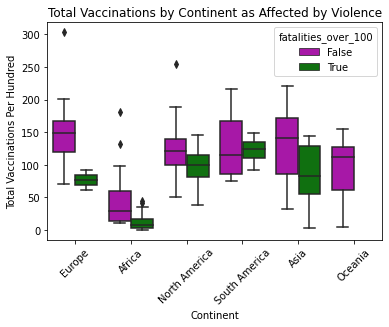

In [9]:
plot = sns.boxplot(x="continent", y="total_vaccinations_per_hundred",
            hue="fatalities_over_100", palette=["m", "g"],
            data=latest)
plot.set_xlabel('Continent')
plot.set_ylabel('Total Vaccinations Per Hundred')
plot.set_title('Total Vaccinations by Continent as Affected by Violence')
plt.xticks(rotation=45)
plot

This plot shows that when separated by continent, mean vaccination rates are higher in countries that have fewer fatalities due to political violence. Let's look at violence over time now.

<AxesSubplot:title={'center':'Deaths from Political Violence over Time'}, xlabel='Date', ylabel='Deaths Due to Political Violence Per Million'>

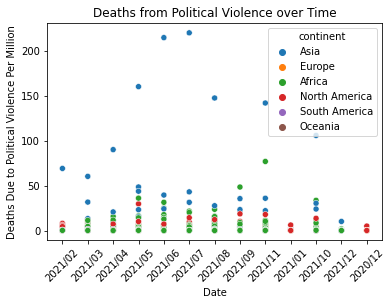

In [10]:
plot = sns.scatterplot(x='year_month', y='death_per_million', data=total, hue='continent')
plot.set_xlabel('Date')
plot.set_ylabel('Deaths Due to Political Violence Per Million')
plot.set_title('Deaths from Political Violence over Time')
plt.xticks(rotation=45)
plot


There does not seem to be a trend for political violence over time. There are several consistent outliers, but that is it. Let's look at vaccinations over time. I would expect it to appear linear and increasing, but maybe it will have some similarities with the political violence.

<AxesSubplot:title={'center':'Vaccinations over Time'}, xlabel='Date', ylabel='Vaccinations Per Hundred'>

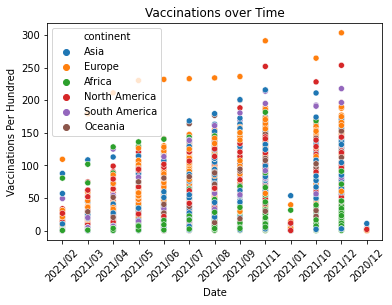

In [11]:
plot = sns.scatterplot(x='year_month', y='vax_month_per_hundred', hue='continent', data=total)
plot.set_xlabel('Date')
plot.set_ylabel('Vaccinations Per Hundred')
plot.set_title('Vaccinations over Time')
plt.xticks(rotation=45)
plot

The graph looks as expected. The last entry appears to be an outlier because there are fewer data points from December going towards the total since that month is still in progress. Let's now look at GDP and HDI.

Text(0.5, 1.0, 'Relation between GDP and Total Vaccinations Distributed')

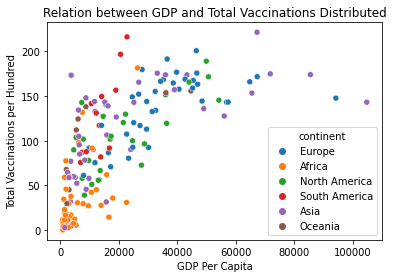

In [12]:
plot = sns.scatterplot(x='gdp_per_capita',y='total_vaccinations_per_hundred',data=latest,hue='continent',legend=True)
plot.set_xlabel('GDP Per Capita')
plot.set_ylabel('Total Vaccinations per Hundred')
plot.set_title('Relation between GDP and Total Vaccinations Distributed')

It looks like GDP has a correlation, though it does not appear that the relation between GDP and vaccinations is linear, it appears logarithmic. Now lets look at HDI.

Text(0.5, 1.0, 'Relation between HDI and Total Vaccinations Distributed')

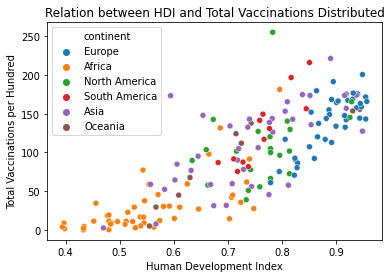

In [13]:
plot = sns.scatterplot(x='human_development_index', y='total_vaccinations_per_hundred', data=latest,hue='continent',legend=True)
plot.set_xlabel('Human Development Index')
plot.set_ylabel('Total Vaccinations per Hundred')
plot.set_title('Relation between HDI and Total Vaccinations Distributed')


There is clearly a strong correlation and a linear relationship between HDI and vaccinations. Let's now see the relation between deaths from political violence and vaccinations.

Text(0.5, 1.0, 'Relation between Political Violence and Total Vaccinations Distributed')

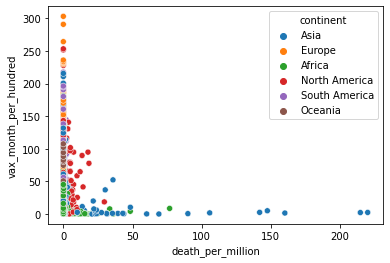

In [14]:
sns.scatterplot(x='death_per_million', y='vax_month_per_hundred',data=total,hue='continent')
plot.set_xlabel('Deaths From Violence Per Million')
plot.set_ylabel('Total Vaccinations per Hundred')
plot.set_title('Relation between Political Violence and Total Vaccinations Distributed')

While it looks like for most observations there is not a strong relationship, for the countries with large amounts of deaths from political violence, the total vaccinations are very low across the board.

Since GDP and HDI are most likely the most important features, let's create a plot to show any correlation that might occur between total vaccinations and these two features.

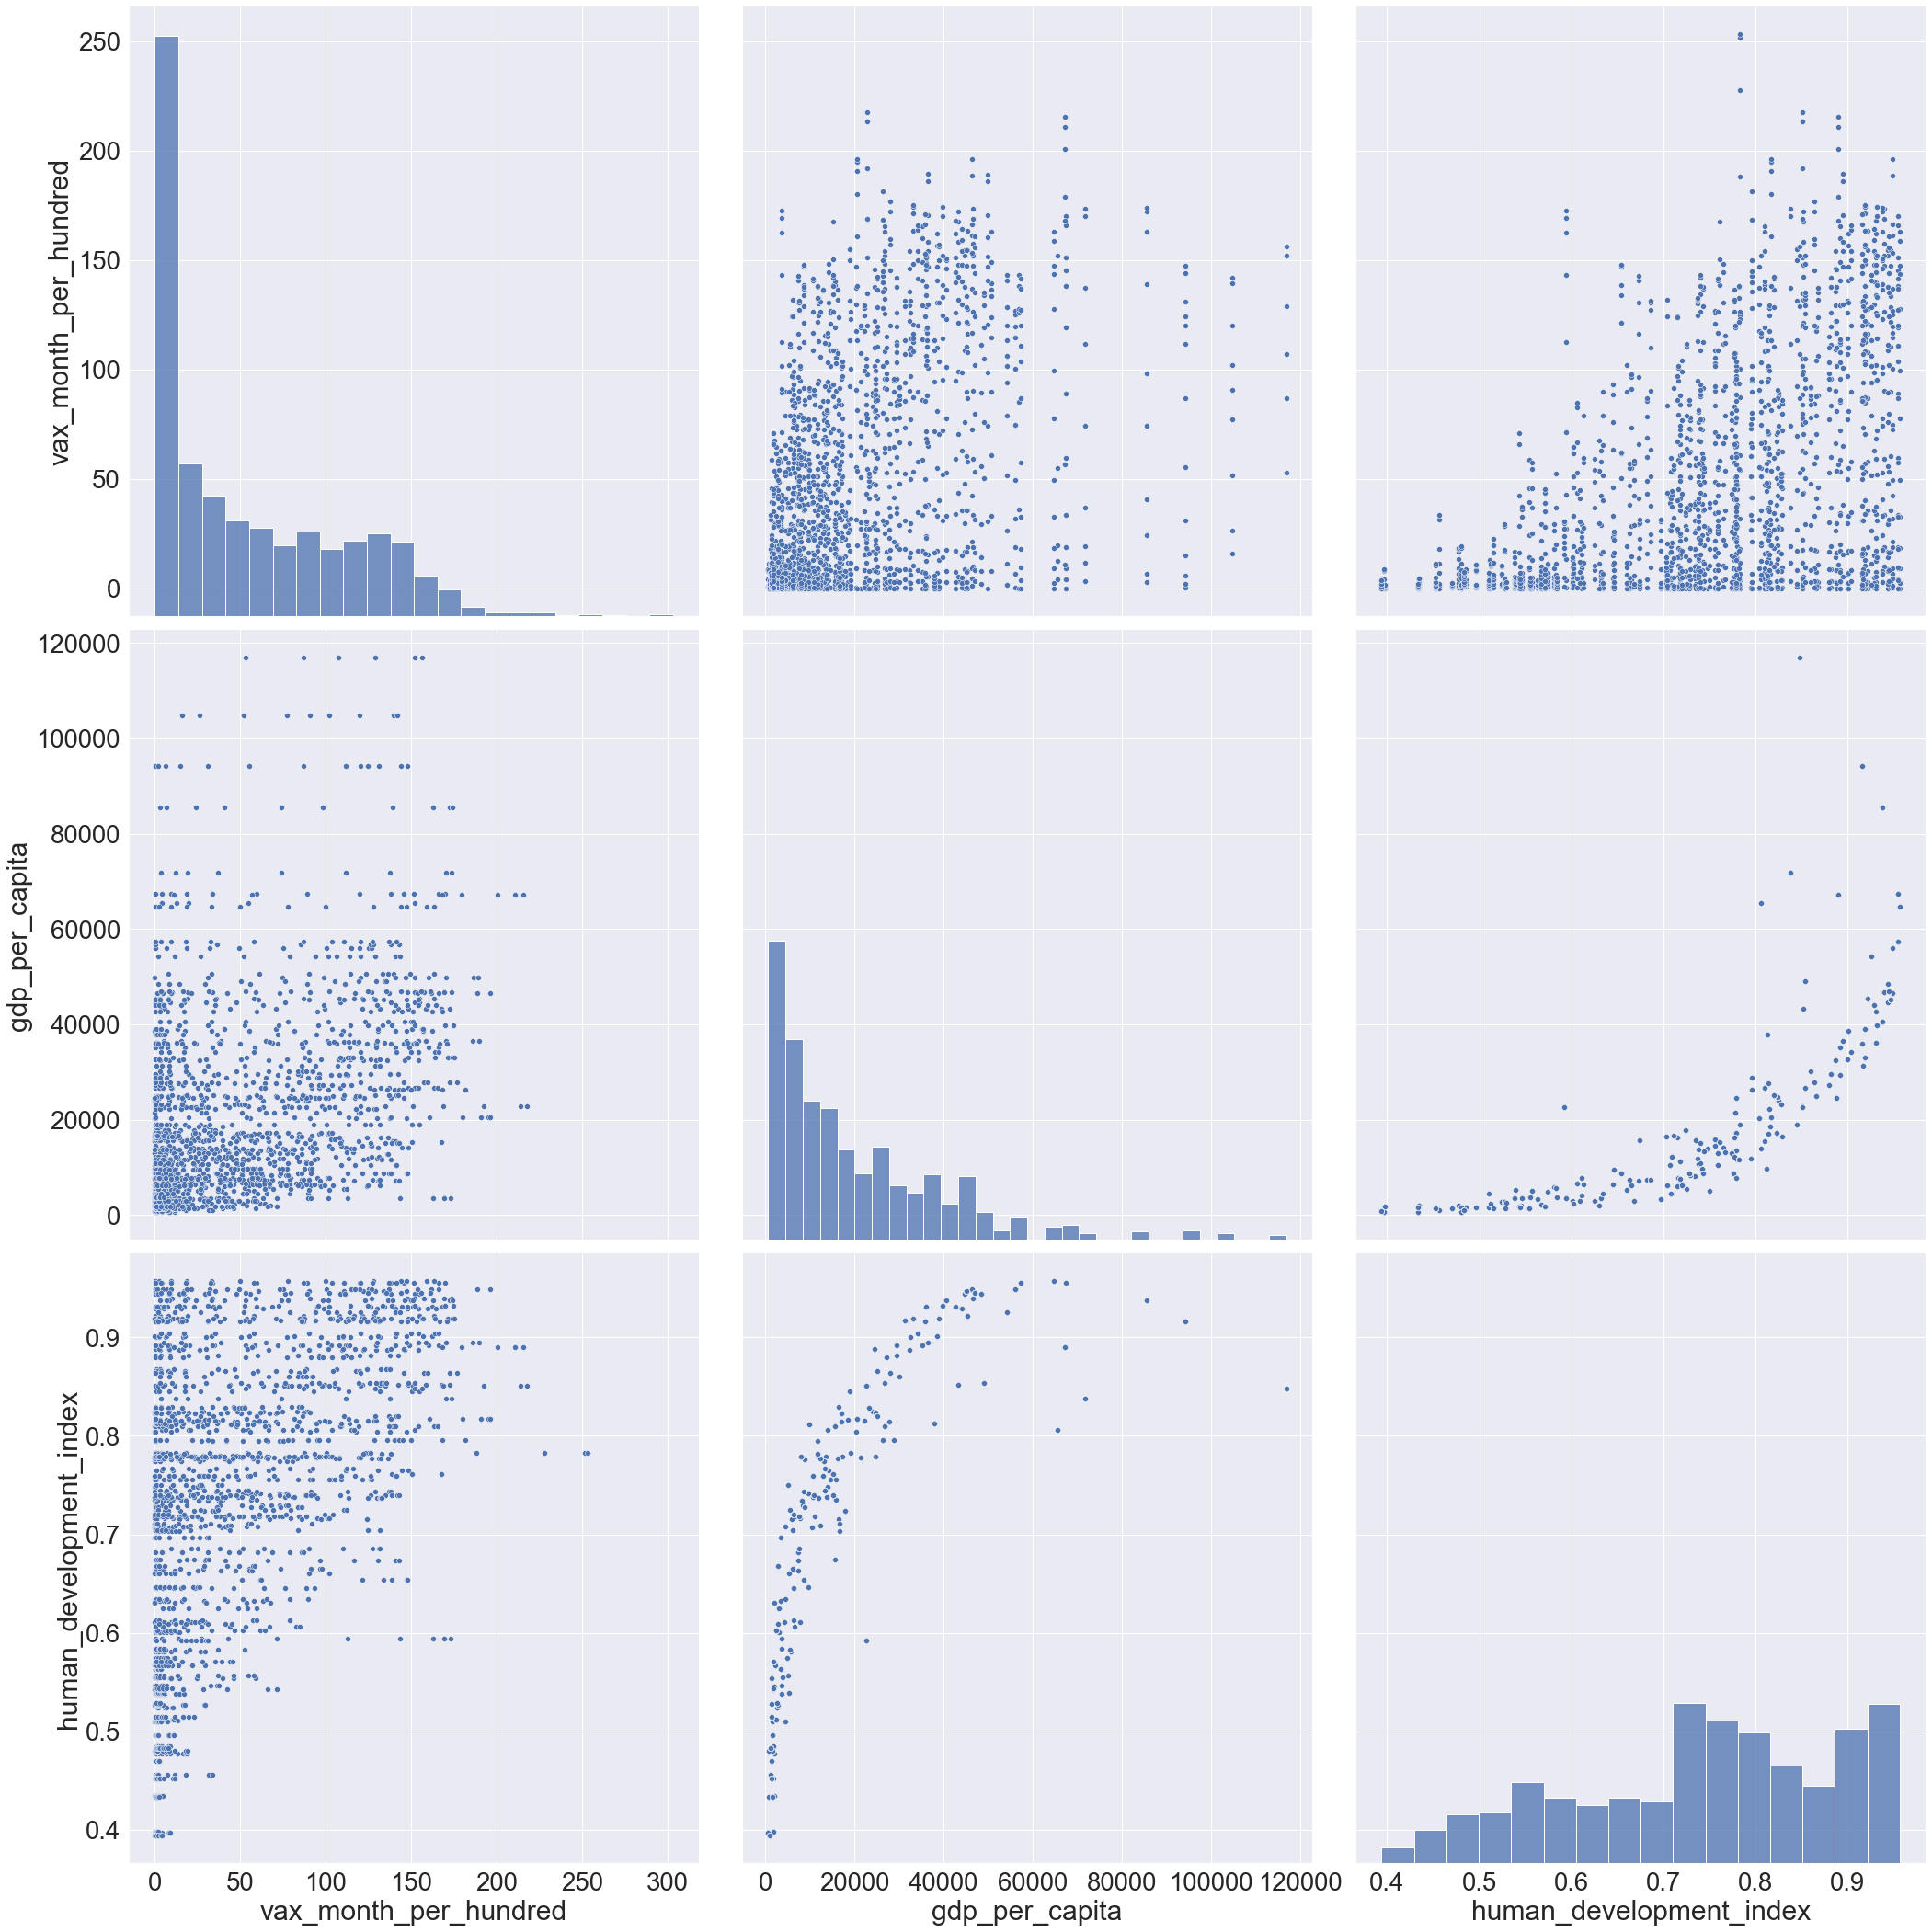

In [15]:
sns.set(font_scale=2.5)
plot = sns.pairplot(total[['vax_month_per_hundred','gdp_per_capita', 'human_development_index']], height=10)

There seems to be correlations among all three of these features. We will now see how these features can be used in creating predictive models for vaccination rates.

## Model Analysis, Hypothesis Testing, and ML

We will now take the features of date, continent, country, human development index, and GDP and use them to create a model that fits the data and will have the ability to predict vaccination rates. In order to be able to use the categorical variables of date, continent and country, we first need to use encodings. For country and continent I chose to use one hot encoding since using an ordinal encoding would negatively impact the algorithms.


In [16]:
# creating the kfold object to do the cross validation computations
cv = KFold(n_splits=20, shuffle=True)
# use ordinal encoder to encode the date feature
ord_enc = OrdinalEncoder()
tot=total
tot.reset_index(inplace = True)
tot["year_month code"] = ord_enc.fit_transform(tot[["year_month"]])
# use one hot encoder to encode the continent and country features
# although this adds over 200 features, it allows for these categorical variables
# to be distinguished from one another without implying order
oe_style = OneHotEncoder()
oe_results = oe_style.fit_transform(tot[["continent"]])
to_add = pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_[0])
oe_results2 = oe_style.fit_transform(tot[["iso_code"]])
to_add = pd.DataFrame(oe_results2.toarray(), columns=oe_style.categories_[0])
tot = pd.concat([tot, to_add], axis=1)


In [17]:
# create the sets for the features and the values meant to be predicted
# all features non-numeric features are removed
y = tot.dropna()['vax_month_per_hundred']
X = tot.dropna().drop(['index','continent', 'year_month','fatalities', 'continent','iso_code','location', 'vax_month_per_hundred'],axis=1)


We can now begin to create models for the data!

For each model in this section the effectiveness will be assessed through the mean of a 20-fold cross validation with the score coming from the R2 value. While the mean will differ every time the code is run, a 20-fold validation should lower the variance of the mean.

The first model that I would like to use is the linear regression model.

In [18]:
clf = LinearRegression()
cross_val_score(clf, X, y, scoring='r2', cv=cv, n_jobs=-1).mean()

0.805784550771128

The mean is approximately .809 during this run of the code. These results are decent for the model. Let's now look at the coefficients for the non-categorical variables.

In [19]:
clf = LinearRegression().fit(X, y)
dir(clf)
d = pd.DataFrame(clf.coef_, columns=['coefficients'])
d['feature name'] = pd.DataFrame(clf.feature_names_in_)
d.head(5)

,coefficients,feature name
0,0.007239,death_per_million
1,-0.001051,population_density
2,0.000801,gdp_per_capita
3,113.728603,human_development_index
4,10.983976,year_month code


From these results we can see that the human development index was the most important variable. Now let's create a Bayesian ridge model!

In [20]:
clf = linear_model.BayesianRidge()
cross_val_score(clf, X, y, scoring='r2', cv=cv, n_jobs=-1).mean()

0.8122832828306722

This model performs slightly better than the linear regression model with a mean score of .811 this run of the code. Let's see if the coefficients of the Bayesian ridge model show similar results to the linear regression model.

In [21]:
clf = linear_model.BayesianRidge().fit(X, y)
dir(clf)
d = pd.DataFrame(clf.coef_, columns=['coefficients'])
d['feature name'] = pd.DataFrame(clf.feature_names_in_)
d.head(5)


,coefficients,feature name
0,-0.010657,death_per_million
1,-0.001048,population_density
2,0.000823,gdp_per_capita
3,108.788314,human_development_index
4,10.938041,year_month code


As expected HDI is the most heavily weighted feature. Now let's make a model using K-nearest neighbors regression.

In [22]:
clf = KNeighborsRegressor(n_neighbors=2)
cross_val_score(clf, X, y, cv=cv,scoring='r2', n_jobs=-1).mean()

0.9635986867209005

This model performs the best of all with a mean R2 of .963 this run of the code. This is a solid model that can hopefully be used to predict future vaccination rates. Let's now make a decision tree regression model.

In [23]:
clf = tree.DecisionTreeRegressor()
cross_val_score(clf, X, y, cv=cv,scoring='r2', n_jobs=-1).mean()

0.8960866174509237

This model performs better than both the linear regression and Bayesian ridge models and worse than the K-nearest neighbors model with a mean score of .899. This model performs decently, but the k-neighbors model is the one that will be used. Let's see which features are most important.

In [24]:
clf = tree.DecisionTreeRegressor().fit(X, y)
d = pd.DataFrame(clf.feature_importances_, columns=['feature importance'])
d['feature name'] = pd.DataFrame(clf.feature_names_in_)
d.sort_values('feature importance', ascending=False).head(15)

,feature importance,feature name
3,0.413802,human_development_index
4,0.374051,year_month code
2,0.077682,gdp_per_capita
1,0.028678,population_density
191,0.012693,SYC
35,0.009992,BTN
210,0.007528,URY
108,0.006447,KHM
119,0.004851,LKA
40,0.004814,CHL


As with the other models the HDI is the most important feature.

## Interpretation

In this exploration of data on Covid vaccines and political violence I was hoping to be able to make some connection between the two. While I was able to create a solid predictive model, the importance of political violence as a feature was small. A couple reasons for this result are that my awareness of current events increased during the pandemic due to the isolation and I had my experience with political violence. I am a DC resident and was in the city during January 6th and the BLM protests. I was peppersprayed by the police a couple of times and barely avoided the photo op tear gas incident. I think that my experience made me overestimate the data. Another reason is that political unrest tends to be an outcome of pandemics and it is still too early for the peak of the unrest https://www.economist.com/the-world-ahead/2021/11/08/the-aftermath-of-the-pandemic-will-make-politics-more-turbulent.

The main outcome of this data is that the Human Development Index is the most important predictive feature of vaccinations. There are three indicators that go into the computations of the HDI: education, life expectancy, and per capita income https://en.wikipedia.org/wiki/Human_Development_Index#Dimensions_and_calculation. My recommendation is to work to increase and improve education in the countries that are lagging. This will not help for vaccinations during this pandemic, but it can help us better prepare to tackle the next one so that we can return to normalcy sooner.